## Hotel Review Analysis & Prediction 

This project presents a supervised regression pipeline to predict hotel review scores based on user demographics, hotel attributes, and satisfaction metrics. The workflow includes data preprocessing, exploratory data analysis (EDA), and model benchmarking using three algorithms: Linear Regression, Random Forest, and XGBoost.

Each model is evaluated using R² and RMSE to assess predictive accuracy and error sensitivity. Visual diagnostics—including actual vs. predicted scatter plots and comparative bar charts—support interpretability and performance assessment. The objective is to identify a reliable, generalizable model that captures the key drivers of customer satisfaction and enables data-informed decision-making in hospitality analytics.

In [1]:
# Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRFRegressor
from sklearn.metrics import r2_score, root_mean_squared_error

## 1. Data Loading and Exploration

In [2]:
# Loading the datasets
hotels = pd.read_csv('hotels.csv')
reviews = pd.read_csv('reviews.csv')
users = pd.read_csv('users.csv')

In [3]:
hotels.head(3)

,hotel_id,hotel_name,city,country,star_rating,lat,lon,cleanliness_base,comfort_base,facilities_base,location_base,staff_base,value_for_money_base
0,1,The Azure Tower,New York,United States,5,40.7580,-73.9855,9.1,8.8,8.9,9.5,8.6,8.0
1,2,The Royal Compass,London,United Kingdom,5,51.5072,-0.1276,9.0,9.2,8.8,9.4,9.0,7.9
2,3,L'Étoile Palace,Paris,France,5,48.8566,2.3522,8.8,9.4,8.7,9.6,9.3,8.1


In [4]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   hotel_id              25 non-null     int64  
 1   hotel_name            25 non-null     object 
 2   city                  25 non-null     object 
 3   country               25 non-null     object 
 4   star_rating           25 non-null     int64  
 5   lat                   25 non-null     float64
 6   lon                   25 non-null     float64
 7   cleanliness_base      25 non-null     float64
 8   comfort_base          25 non-null     float64
 9   facilities_base       25 non-null     float64
 10  location_base         25 non-null     float64
 11  staff_base            25 non-null     float64
 12  value_for_money_base  25 non-null     float64
dtypes: float64(8), int64(2), object(3)
memory usage: 2.7+ KB


In [5]:
reviews.head(2)

,review_id,user_id,hotel_id,review_date,score_overall,score_cleanliness,score_comfort,score_facilities,score_location,score_staff,score_value_for_money,review_text
0,1,1600,1,2022-10-07,8.7,8.6,8.7,8.5,9.0,8.8,8.7,Practice reduce young our because machine. Rec...
1,2,432,4,2020-03-24,9.1,10.0,9.1,9.0,8.6,9.4,8.6,Test cover traditional black. Process tell Mr ...


In [6]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   review_id              50000 non-null  int64  
 1   user_id                50000 non-null  int64  
 2   hotel_id               50000 non-null  int64  
 3   review_date            50000 non-null  object 
 4   score_overall          50000 non-null  float64
 5   score_cleanliness      50000 non-null  float64
 6   score_comfort          50000 non-null  float64
 7   score_facilities       50000 non-null  float64
 8   score_location         50000 non-null  float64
 9   score_staff            50000 non-null  float64
 10  score_value_for_money  50000 non-null  float64
 11  review_text            50000 non-null  object 
dtypes: float64(7), int64(3), object(2)
memory usage: 4.6+ MB


In [7]:
users.head(3)

,user_id,user_gender,country,age_group,traveller_type,join_date
0,1,Female,United Kingdom,35-44,Solo,2024-09-29
1,2,Male,United Kingdom,25-34,Solo,2023-11-29
2,3,Female,Mexico,25-34,Family,2022-04-03


In [8]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   user_id         2000 non-null   int64 
 1   user_gender     2000 non-null   object
 2   country         2000 non-null   object
 3   age_group       2000 non-null   object
 4   traveller_type  2000 non-null   object
 5   join_date       2000 non-null   object
dtypes: int64(1), object(5)
memory usage: 93.9+ KB


In [9]:
print(hotels.shape)
print(reviews.shape)
print(users.shape)

(25, 13)
(50000, 12)
(2000, 6)


In [10]:
# Merge hotel metadata with review data on shared hotel_id key
df = hotels.merge(reviews, on='hotel_id')

# Enrich merged data with user profile information via user_id
df = df.merge(users, on='user_id')

In [11]:
# Rename ambiguous 'country' columns to clarify hotel vs. user origin
df.rename(columns={'country_x': 'hotel_county', 'country_y': 'user_country'}, inplace=True)

In [12]:
df.head(3)

,hotel_id,hotel_name,city,hotel_county,star_rating,lat,lon,cleanliness_base,comfort_base,facilities_base,...,score_facilities,score_location,score_staff,score_value_for_money,review_text,user_gender,user_country,age_group,traveller_type,join_date
0,1,The Azure Tower,New York,United States,5,40.758,-73.9855,9.1,8.8,8.9,...,8.5,9.0,8.8,8.7,Practice reduce young our because machine. Rec...,Female,New Zealand,25-34,Solo,2021-03-21
1,1,The Azure Tower,New York,United States,5,40.758,-73.9855,9.1,8.8,8.9,...,8.4,8.9,8.7,8.4,Summer leader sea. Civil morning operation amo...,Female,Spain,55+,Solo,2023-10-05
2,1,The Azure Tower,New York,United States,5,40.758,-73.9855,9.1,8.8,8.9,...,9.1,9.5,9.1,7.5,Apply need explain movement wait above bar. Tu...,Male,Australia,25-34,Business,2021-12-18


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   hotel_id               50000 non-null  int64  
 1   hotel_name             50000 non-null  object 
 2   city                   50000 non-null  object 
 3   hotel_county           50000 non-null  object 
 4   star_rating            50000 non-null  int64  
 5   lat                    50000 non-null  float64
 6   lon                    50000 non-null  float64
 7   cleanliness_base       50000 non-null  float64
 8   comfort_base           50000 non-null  float64
 9   facilities_base        50000 non-null  float64
 10  location_base          50000 non-null  float64
 11  staff_base             50000 non-null  float64
 12  value_for_money_base   50000 non-null  float64
 13  review_id              50000 non-null  int64  
 14  user_id                50000 non-null  int64  
 15  re

In [14]:
# Check for missing values
df.isnull().sum()

hotel_id                 0
hotel_name               0
city                     0
hotel_county             0
star_rating              0
lat                      0
lon                      0
cleanliness_base         0
comfort_base             0
facilities_base          0
location_base            0
staff_base               0
value_for_money_base     0
review_id                0
user_id                  0
review_date              0
score_overall            0
score_cleanliness        0
score_comfort            0
score_facilities         0
score_location           0
score_staff              0
score_value_for_money    0
review_text              0
user_gender              0
user_country             0
age_group                0
traveller_type           0
join_date                0
dtype: int64

In [15]:
df.tail(3)

,hotel_id,hotel_name,city,hotel_county,star_rating,lat,lon,cleanliness_base,comfort_base,facilities_base,...,score_facilities,score_location,score_staff,score_value_for_money,review_text,user_gender,user_country,age_group,traveller_type,join_date
49997,25,The Kiwi Grand,Wellington,New Zealand,5,-41.2865,174.7762,9.3,9.2,9.1,...,8.3,8.6,8.8,8.5,Interesting outside question question forget. ...,Male,Germany,25-34,Couple,2022-07-12
49998,25,The Kiwi Grand,Wellington,New Zealand,5,-41.2865,174.7762,9.3,9.2,9.1,...,8.1,9.3,9.0,8.7,Dinner apply or mention various.\nSince defens...,Female,United Kingdom,55+,Couple,2022-06-13
49999,25,The Kiwi Grand,Wellington,New Zealand,5,-41.2865,174.7762,9.3,9.2,9.1,...,8.7,8.6,9.4,9.0,Analysis miss continue him bill according cond...,Other,United Kingdom,25-34,Solo,2024-02-09


In [16]:
df.describe()

,hotel_id,star_rating,lat,lon,cleanliness_base,comfort_base,facilities_base,location_base,staff_base,value_for_money_base,review_id,user_id,score_overall,score_cleanliness,score_comfort,score_facilities,score_location,score_staff,score_value_for_money
count,50000.000000,50000.0,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,13.051100,5.0,20.882112,34.468497,9.091592,9.063918,8.917196,9.270406,9.015730,8.513232,25000.500000,1005.567540,8.943460,9.052558,9.024404,8.743062,9.176410,8.972076,8.434540
std,7.203808,0.0,30.437484,73.576721,0.226334,0.234129,0.286064,0.347649,0.236695,0.258259,14433.901067,576.711855,0.180878,0.504296,0.423927,0.498320,0.421086,0.397775,0.529321
min,1.000000,5.0,-41.286500,-99.133200,8.700000,8.600000,8.500000,8.500000,8.600000,7.900000,1.000000,1.000000,8.200000,7.700000,7.900000,7.600000,7.900000,7.900000,6.800000
25%,7.000000,5.0,6.524400,2.173400,8.900000,8.900000,8.700000,9.000000,8.800000,8.400000,12500.750000,507.000000,8.800000,8.700000,8.700000,8.400000,8.900000,8.700000,8.100000
50%,13.000000,5.0,31.230400,18.424100,9.100000,9.100000,8.900000,9.300000,9.000000,8.500000,25000.500000,1010.000000,8.900000,9.100000,9.000000,8.700000,9.200000,9.000000,8.500000
75%,19.000000,5.0,41.902800,100.501800,9.300000,9.200000,9.100000,9.600000,9.200000,8.700000,37500.250000,1504.000000,9.100000,9.400000,9.300000,9.100000,9.500000,9.200000,8.800000
max,25.000000,5.0,55.755800,174.776200,9.600000,9.500000,9.600000,9.800000,9.500000,8.900000,50000.000000,2000.000000,9.600000,10.000000,10.000000,10.000000,10.000000,10.000000,9.700000


## 2. Exploratory Data Analysis (EDA)

In [17]:
df.dtypes

hotel_id                   int64
hotel_name                object
city                      object
hotel_county              object
star_rating                int64
lat                      float64
lon                      float64
cleanliness_base         float64
comfort_base             float64
facilities_base          float64
location_base            float64
staff_base               float64
value_for_money_base     float64
review_id                  int64
user_id                    int64
review_date               object
score_overall            float64
score_cleanliness        float64
score_comfort            float64
score_facilities         float64
score_location           float64
score_staff              float64
score_value_for_money    float64
review_text               object
user_gender               object
user_country              object
age_group                 object
traveller_type            object
join_date                 object
dtype: object

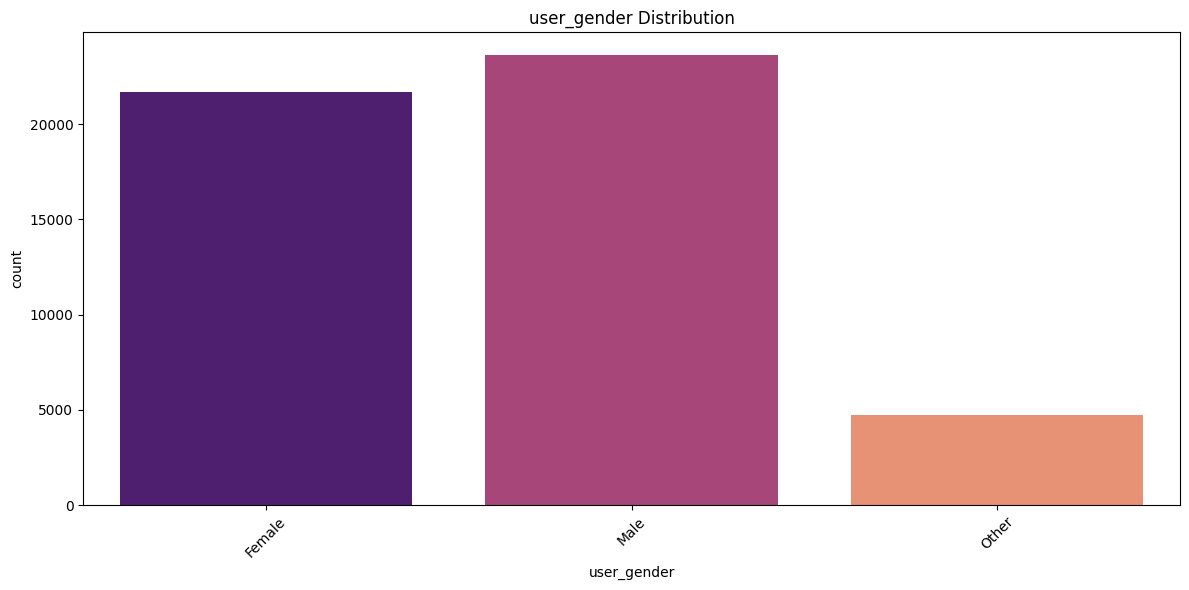

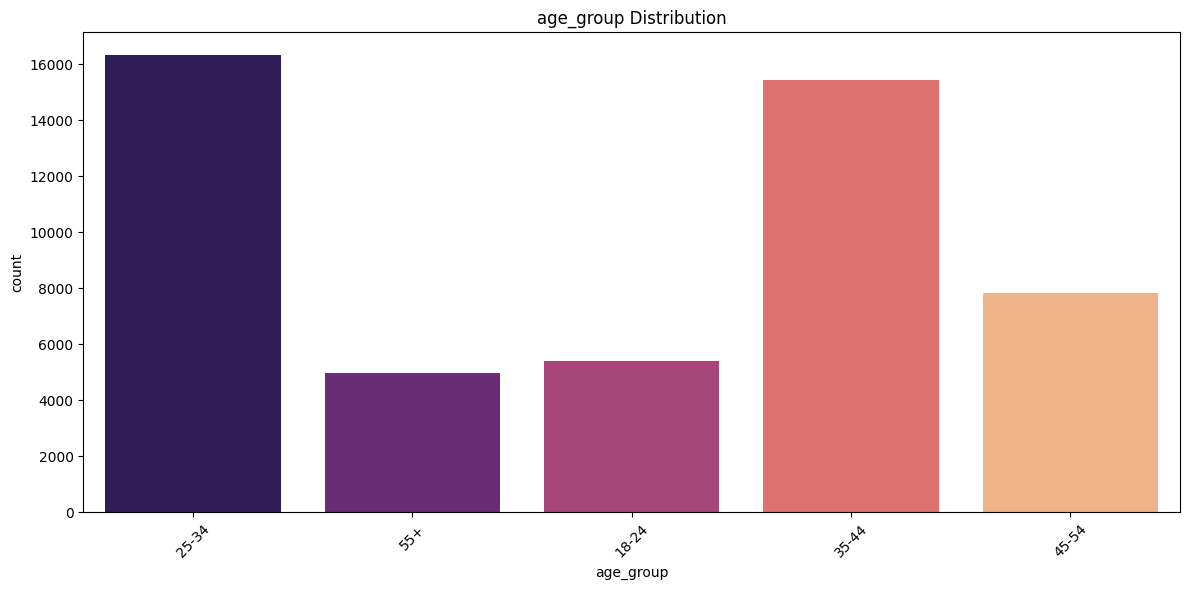

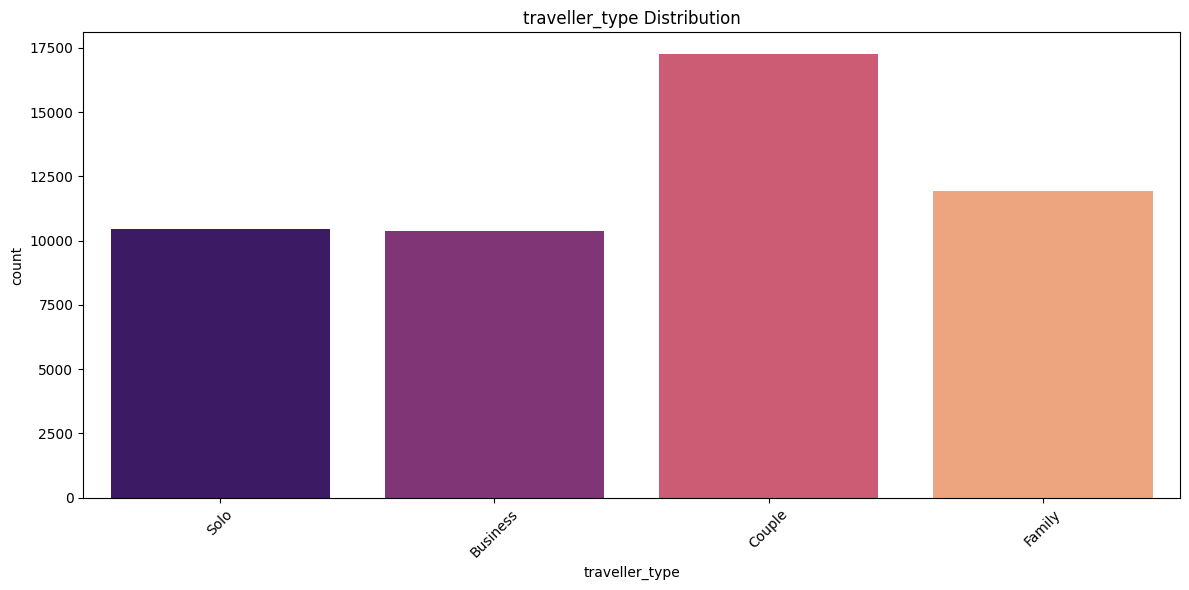

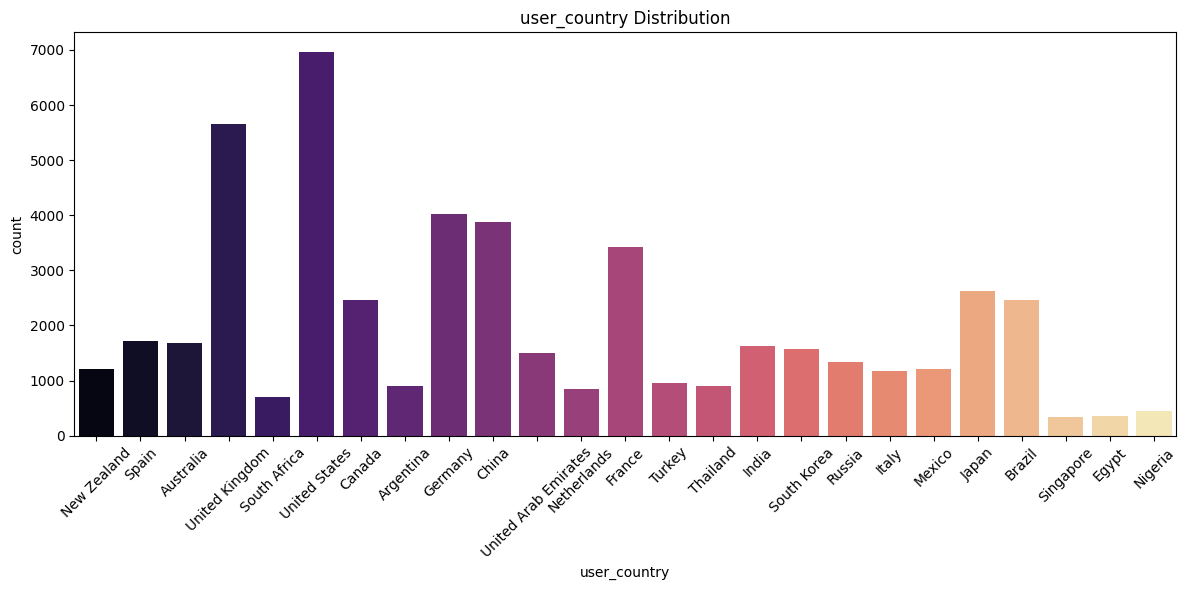

In [18]:
user_cols = ['user_gender', 'age_group', 'traveller_type', 'user_country']

# Visualize distribution of key user demographics and travel traits
for col in user_cols:
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df, x=col, palette='magma')
    plt.title(f'{col} Distribution')
    plt.xticks(rotation=45)
    plt.tight_layout()

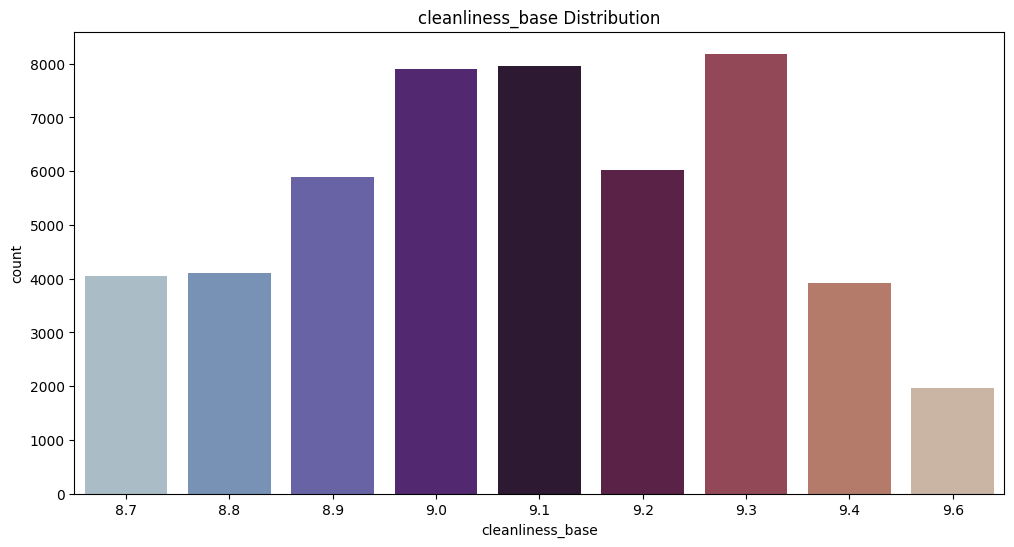

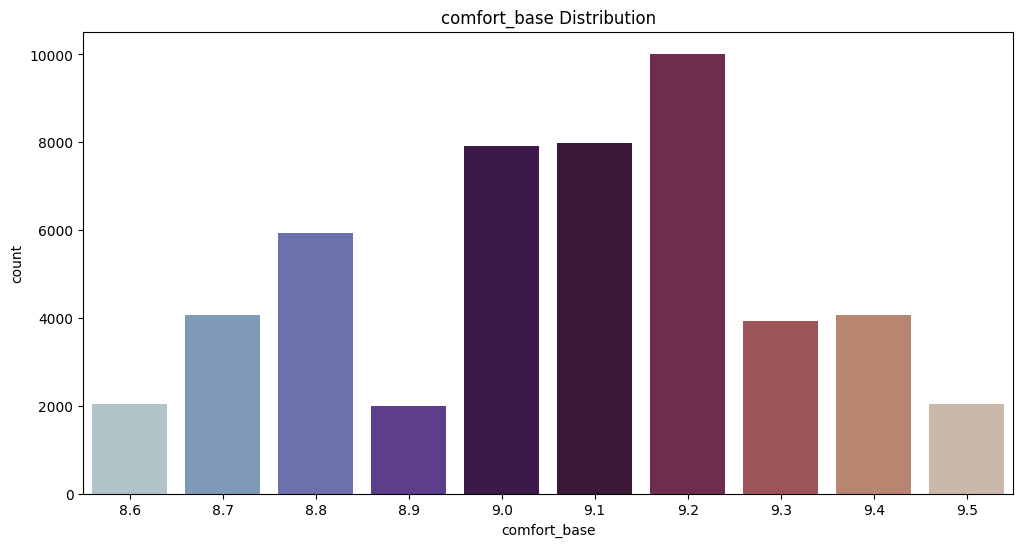

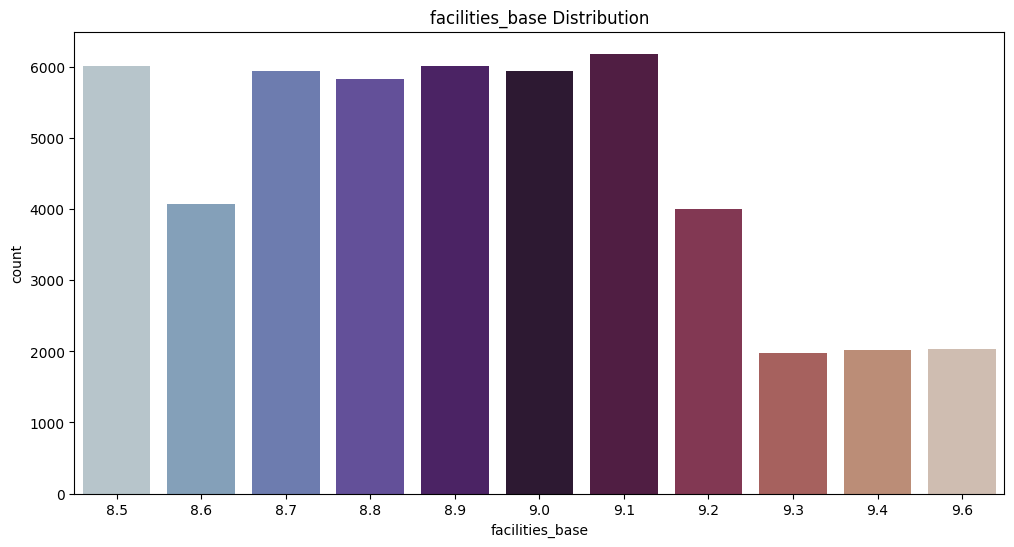

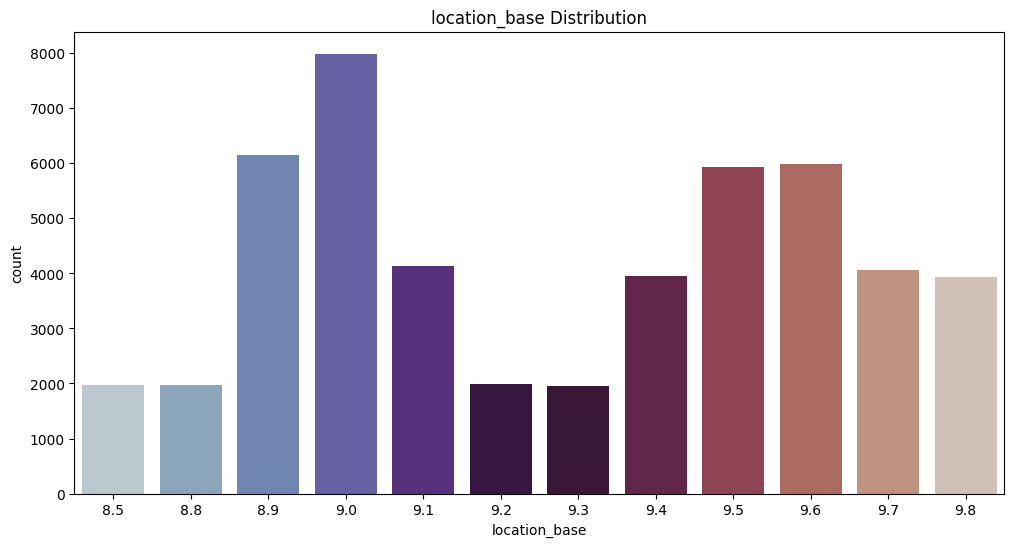

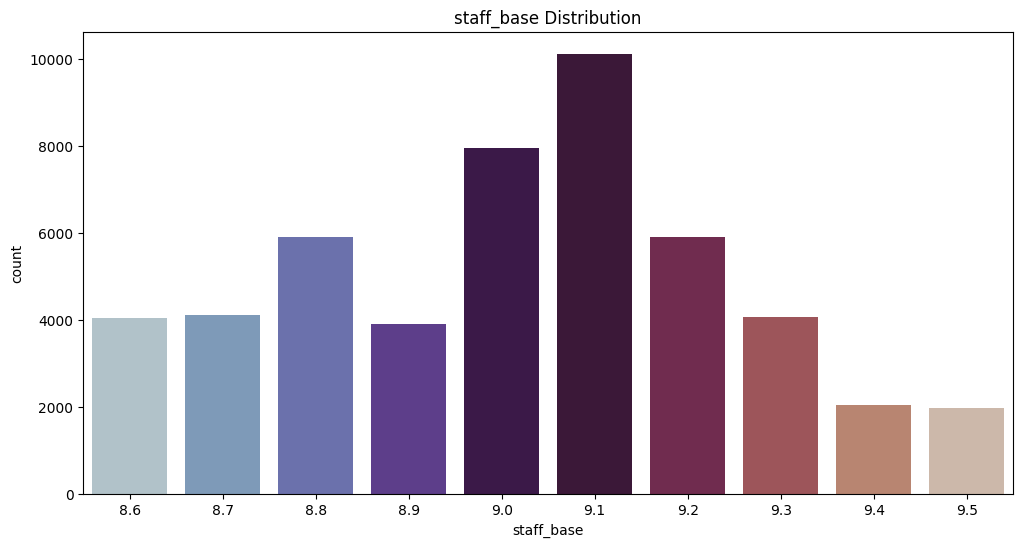

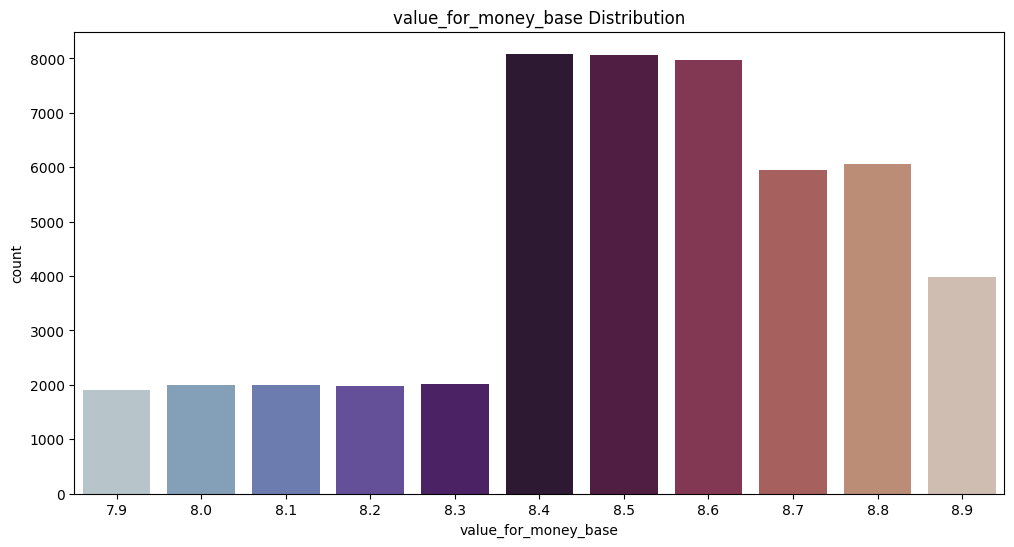

In [19]:
hotel_cols = ['cleanliness_base', 'comfort_base', 'facilities_base', 'location_base', 'staff_base', 'value_for_money_base']

# Plot distribution of user ratings across core hotel attributes
for col in hotel_cols:
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df, x=col, palette='twilight')
    plt.title(f'{col} Distribution')

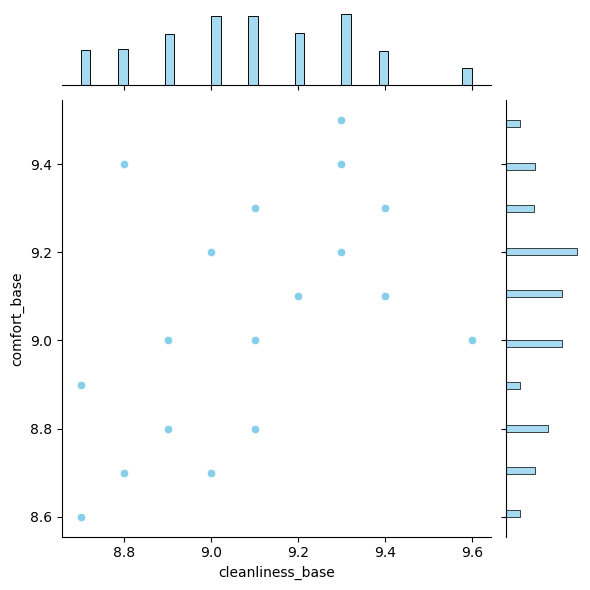

In [20]:
# Analyze relationship between cleanliness and comfort ratings with joint distribution view
sns.jointplot(data=df, x='cleanliness_base', y='comfort_base', color='skyblue')

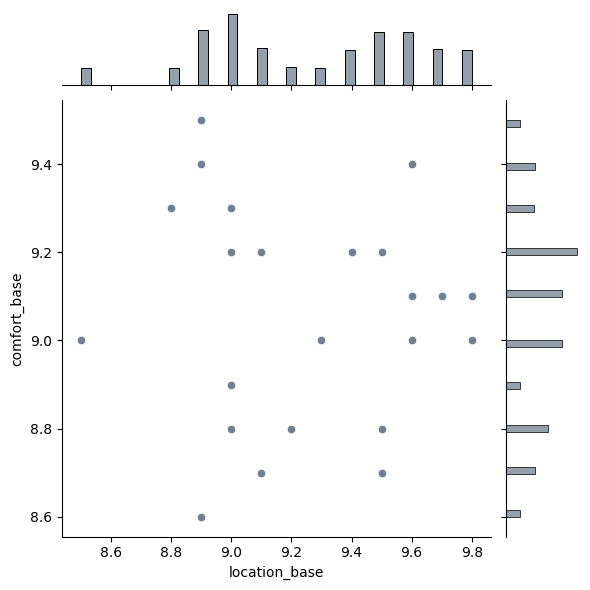

In [21]:
# Analyze relationship between location and comfort ratings with joint distribution view
sns.jointplot(data=df, x='location_base', y='comfort_base', color='slategray')   

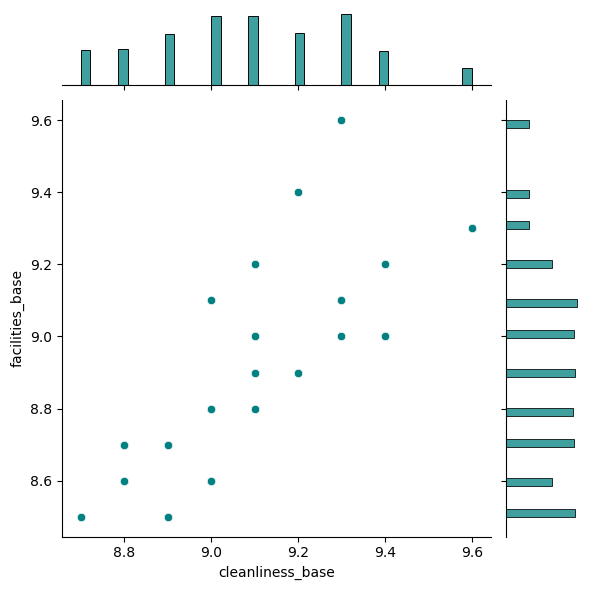

In [22]:
# Analyze relationship between cleanliness and facilities ratings with joint distribution view
sns.jointplot(data=df, x='cleanliness_base', y='facilities_base', color='teal')

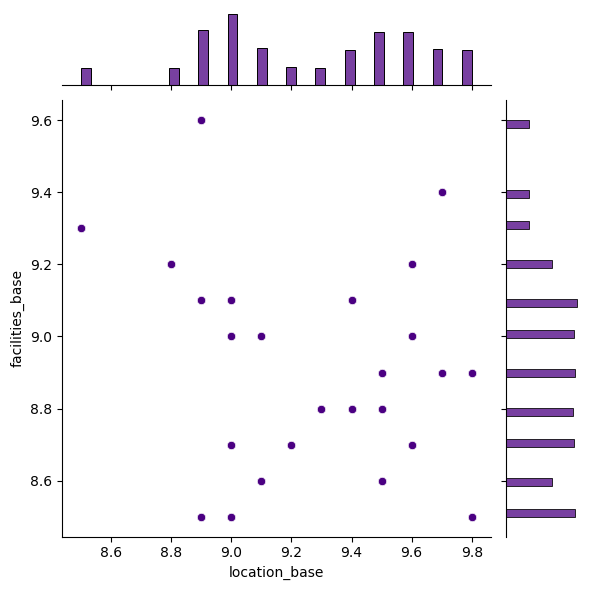

In [23]:
# Analyze relationship between location and facilities ratings with joint distribution view
sns.jointplot(data=df, x='location_base', y='facilities_base', color='indigo')

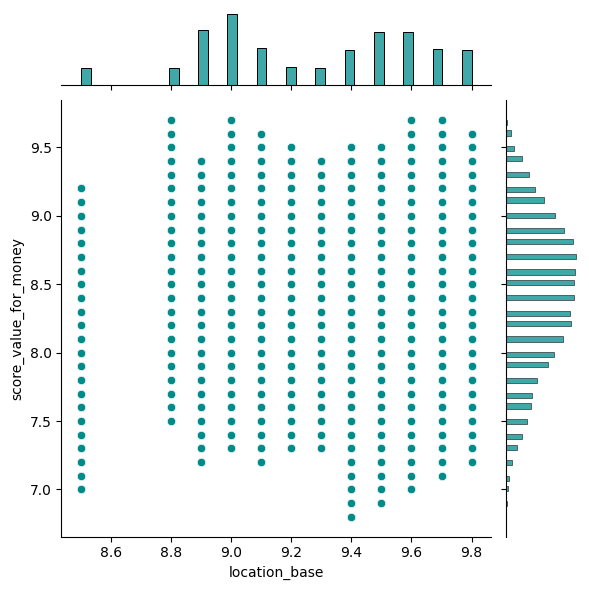

In [24]:
# Analyze relationship between location and value for money ratings with joint distribution view
sns.jointplot(data=df, x='location_base', y='score_value_for_money', color='darkcyan')

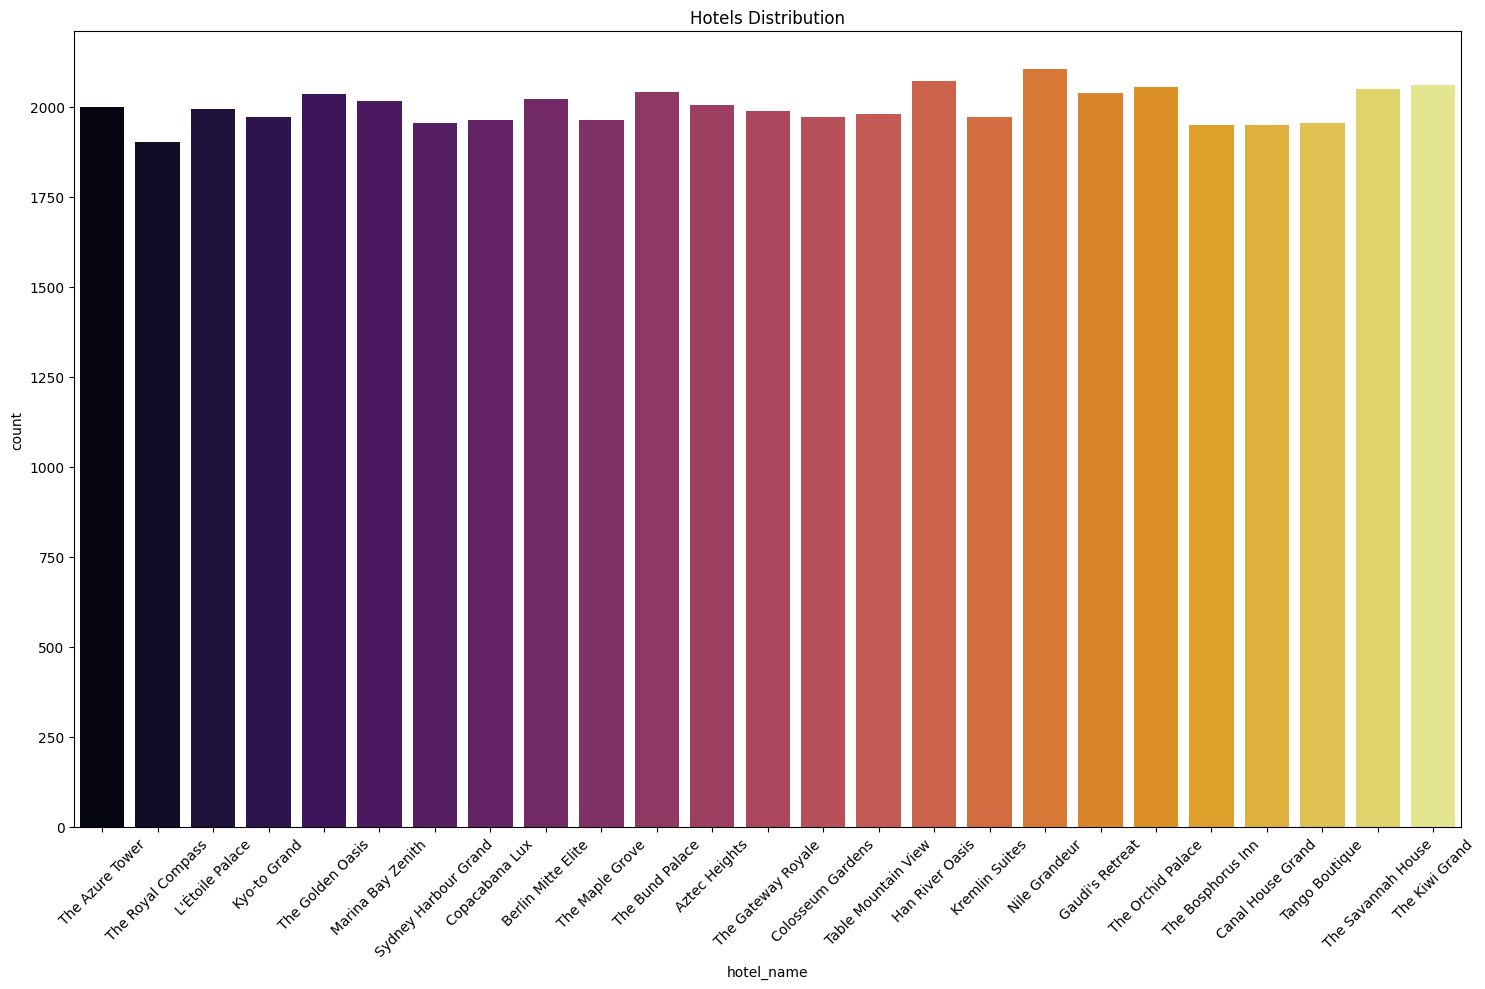

In [25]:
# Hotels name distribution
plt.figure(figsize=(15, 10))
sns.countplot(data=df, x='hotel_name', palette='inferno')
plt.title('Hotels Distribution')
plt.xticks(rotation=45)
plt.tight_layout()

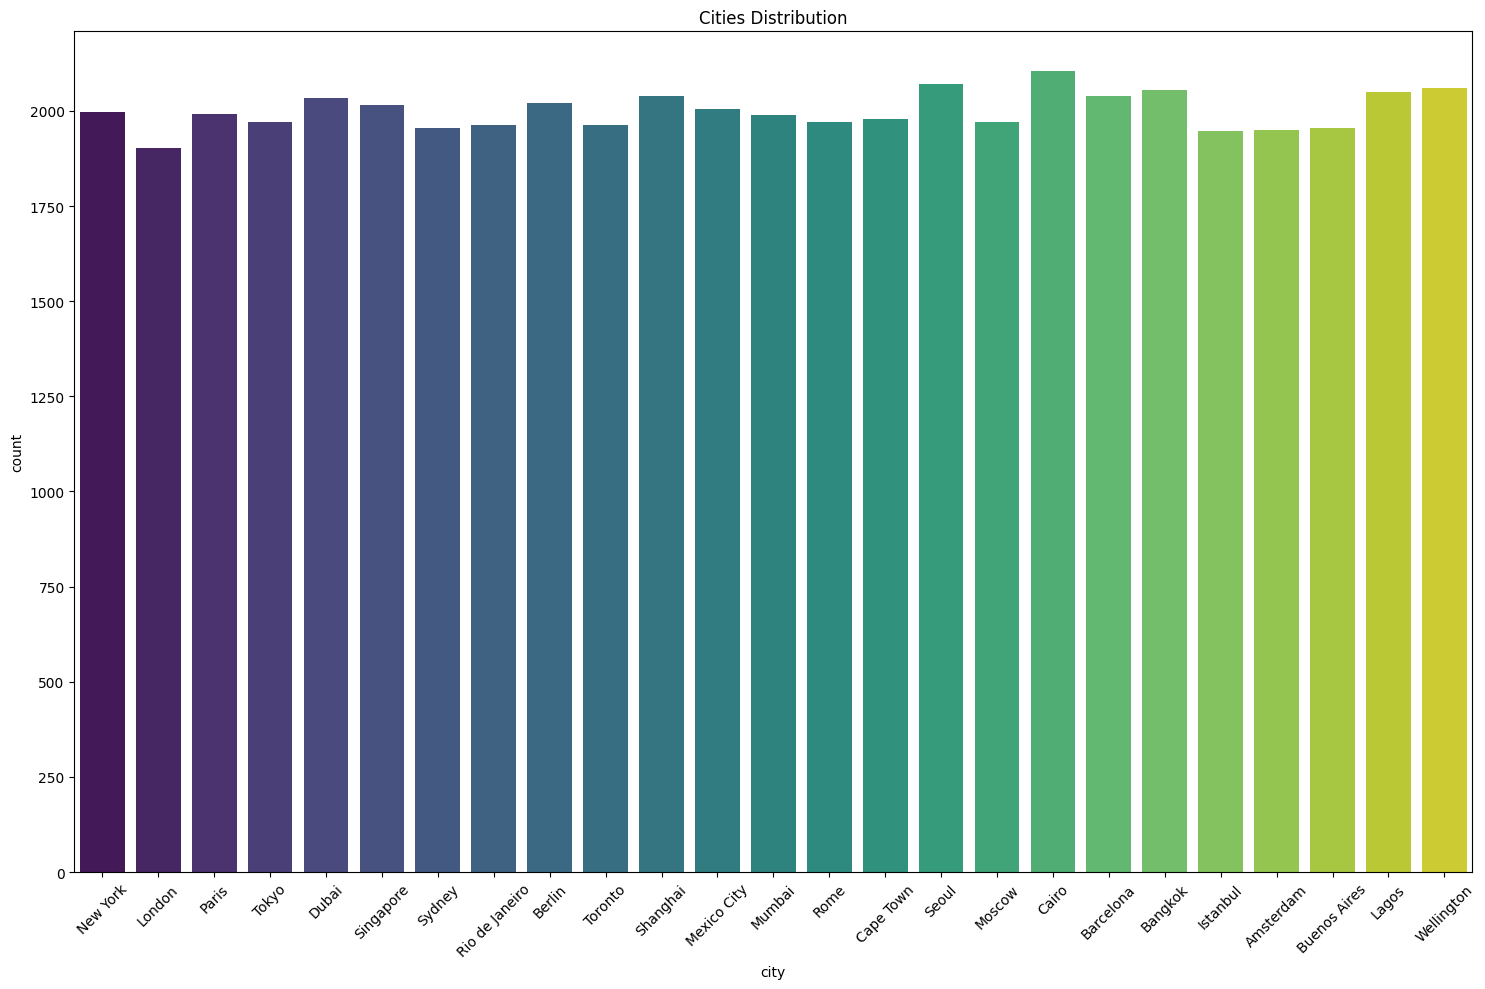

In [26]:
# Cities review distribution
plt.figure(figsize=(15, 10))
sns.countplot(data=df, x='city', palette='viridis')
plt.title('Cities Distribution')
plt.xticks(rotation=45)
plt.tight_layout()

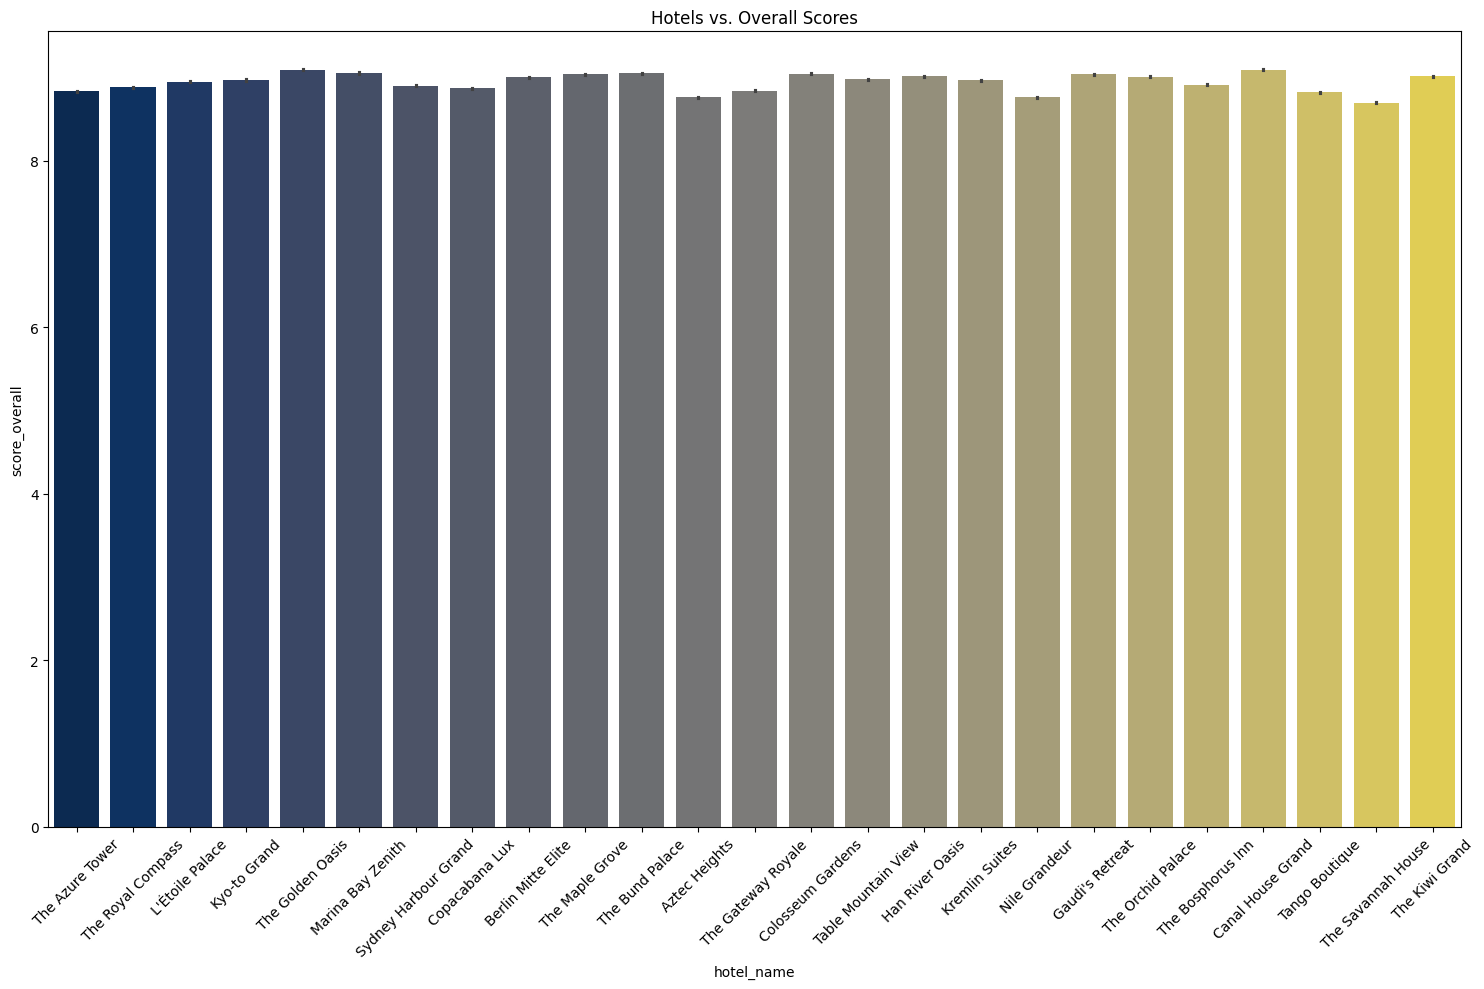

In [27]:
# Hotels vs. Overal score distribution
plt.figure(figsize=(15, 10))
sns.barplot(data=df, x='hotel_name', y='score_overall', palette='cividis')
plt.title('Hotels vs. Overall Scores')
plt.xticks(rotation=45)
plt.tight_layout()

In [28]:
# Calculate average overall score per hotel
df.groupby('hotel_name')['score_overall'].mean()

hotel_name
Aztec Heights           8.759381
Berlin Mitte Elite      9.002324
Canal House Grand       9.090713
Colosseum Gardens       9.044140
Copacabana Lux          8.869113
Gaudi's Retreat         9.036734
Han River Oasis         9.016997
Kremlin Suites          8.966954
Kyo-to Grand            8.969457
L'Étoile Palace         8.947065
Marina Bay Zenith       9.053598
Nile Grandeur           8.759696
Sydney Harbour Grand    8.901228
Table Mountain View     8.979434
Tango Boutique          8.822495
The Azure Tower         8.835135
The Bosphorus Inn       8.913655
The Bund Palace         9.050441
The Gateway Royale      8.841227
The Golden Oasis        9.092432
The Kiwi Grand          9.016311
The Maple Grove         9.035692
The Orchid Palace       9.006521
The Royal Compass       8.881020
The Savannah House      8.694632
Name: score_overall, dtype: float64

In [29]:
df.columns

Index(['hotel_id', 'hotel_name', 'city', 'hotel_county', 'star_rating', 'lat',
       'lon', 'cleanliness_base', 'comfort_base', 'facilities_base',
       'location_base', 'staff_base', 'value_for_money_base', 'review_id',
       'user_id', 'review_date', 'score_overall', 'score_cleanliness',
       'score_comfort', 'score_facilities', 'score_location', 'score_staff',
       'score_value_for_money', 'review_text', 'user_gender', 'user_country',
       'age_group', 'traveller_type', 'join_date'],
      dtype='object')

<Figure size 1200x600 with 0 Axes>

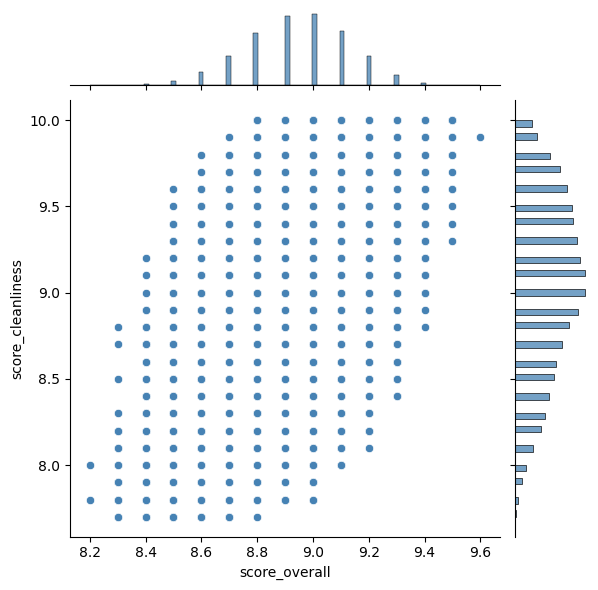

<Figure size 1200x600 with 0 Axes>

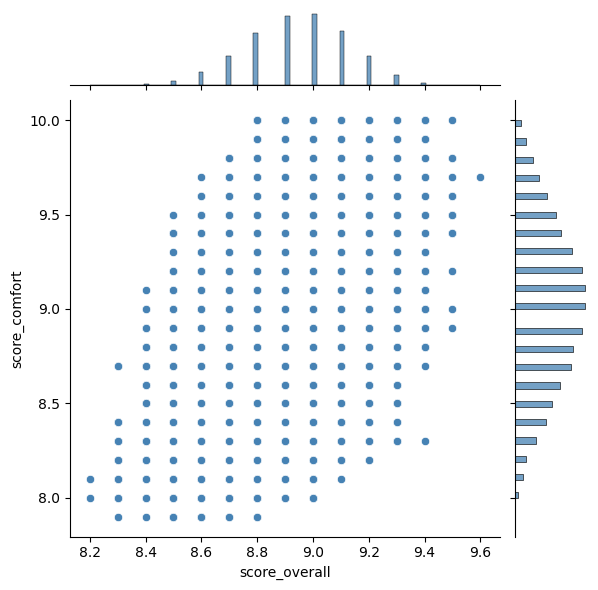

<Figure size 1200x600 with 0 Axes>

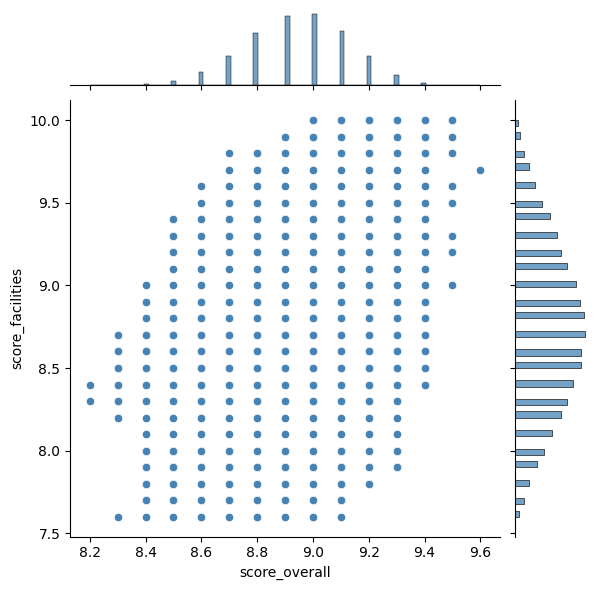

<Figure size 1200x600 with 0 Axes>

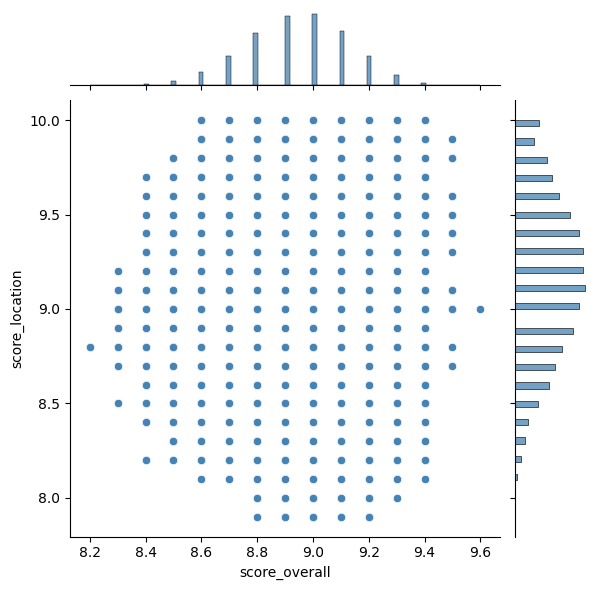

<Figure size 1200x600 with 0 Axes>

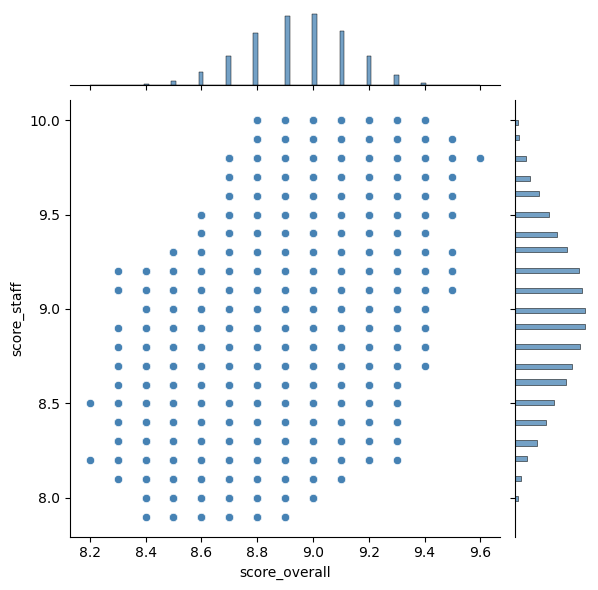

<Figure size 1200x600 with 0 Axes>

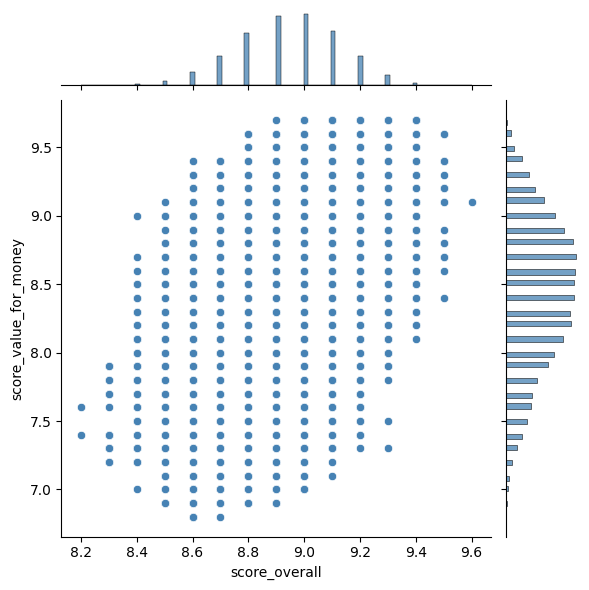

In [30]:
score_cols = ['score_cleanliness', 'score_comfort', 'score_facilities',
              'score_location', 'score_staff', 'score_value_for_money']

# Compare overall score with individual category ratings using joint plots
for col in score_cols:
    plt.figure(figsize=(12,6))
    sns.jointplot(data=df, x='score_overall', y=col, color='steelblue')

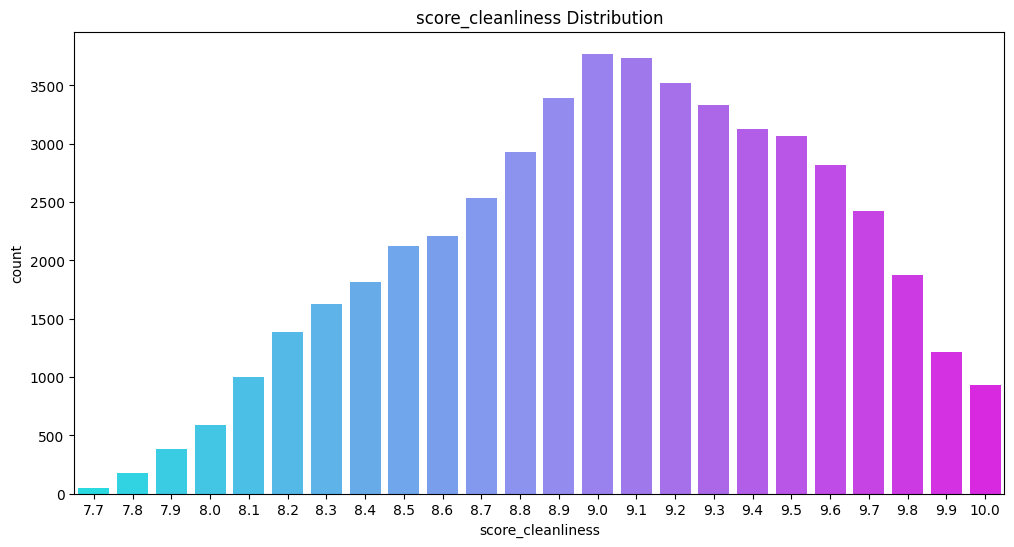

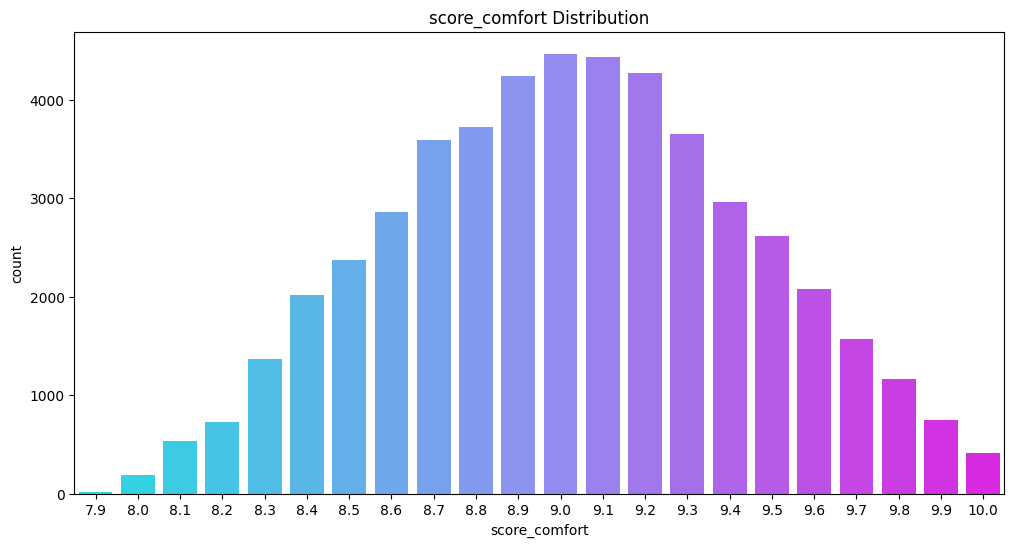

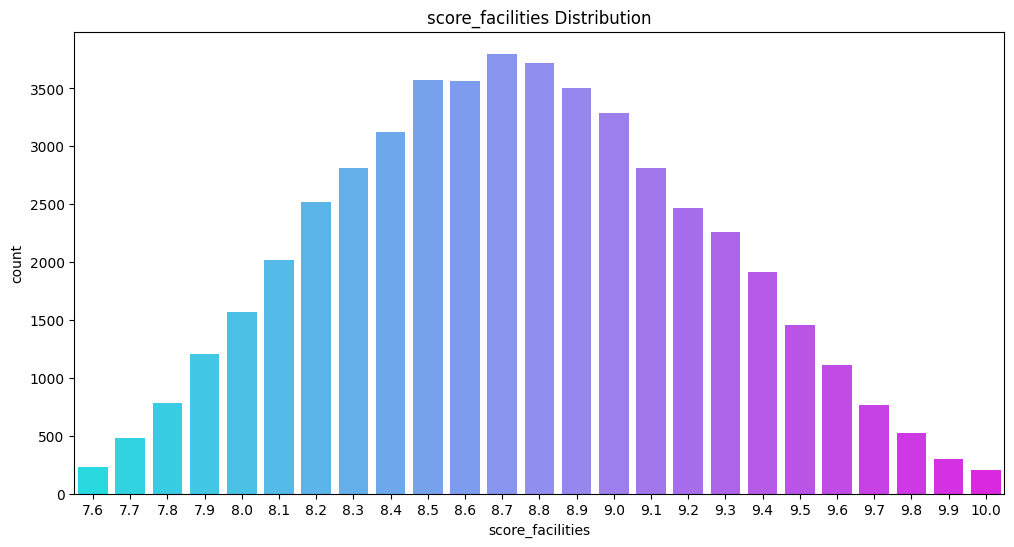

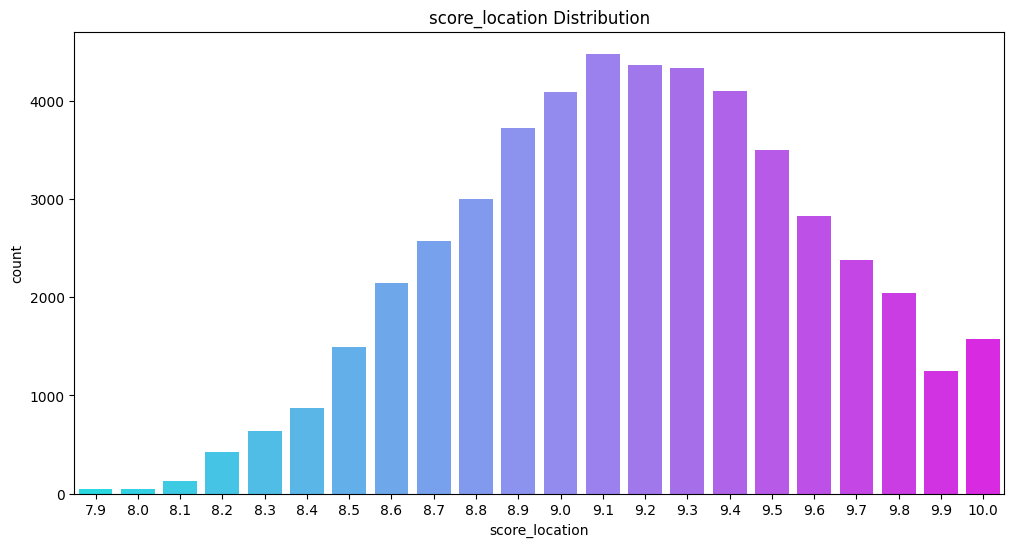

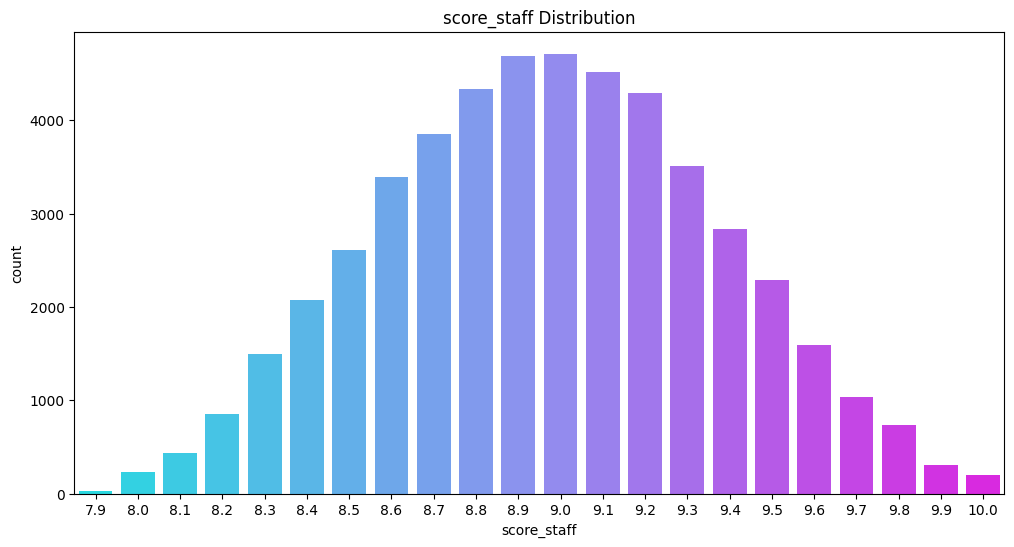

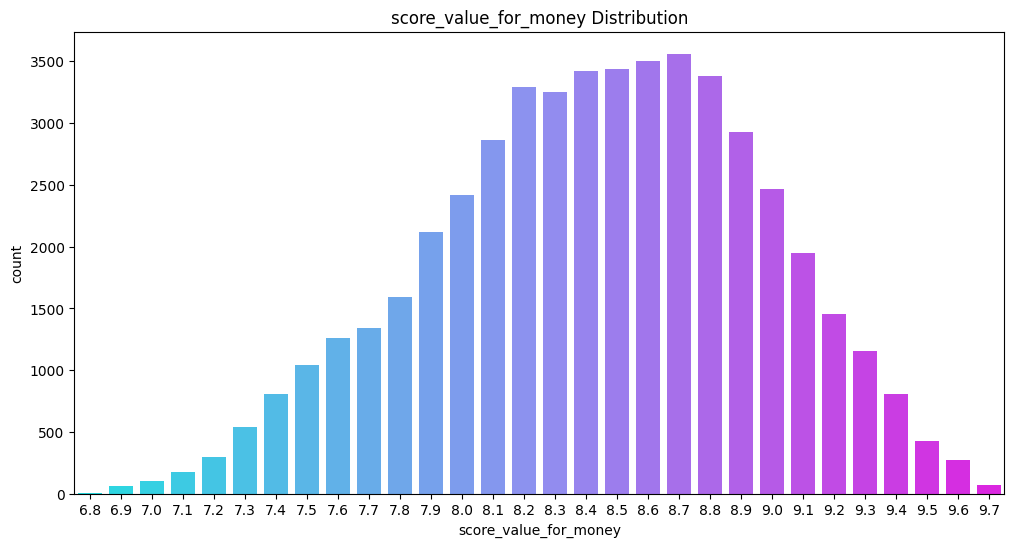

In [31]:
for col in score_cols:
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df, x=col, palette='cool')
    plt.title(f'{col} Distribution')

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5]),
 [Text(0, 0.5, 'hotel_id'),
  Text(0, 1.5, 'lat'),
  Text(0, 2.5, 'lon'),
  Text(0, 3.5, 'cleanliness_base'),
  Text(0, 4.5, 'comfort_base'),
  Text(0, 5.5, 'facilities_base'),
  Text(0, 6.5, 'location_base'),
  Text(0, 7.5, 'staff_base'),
  Text(0, 8.5, 'value_for_money_base'),
  Text(0, 9.5, 'review_id'),
  Text(0, 10.5, 'user_id'),
  Text(0, 11.5, 'score_overall'),
  Text(0, 12.5, 'score_cleanliness'),
  Text(0, 13.5, 'score_comfort'),
  Text(0, 14.5, 'score_facilities'),
  Text(0, 15.5, 'score_location'),
  Text(0, 16.5, 'score_staff'),
  Text(0, 17.5, 'score_value_for_money')])

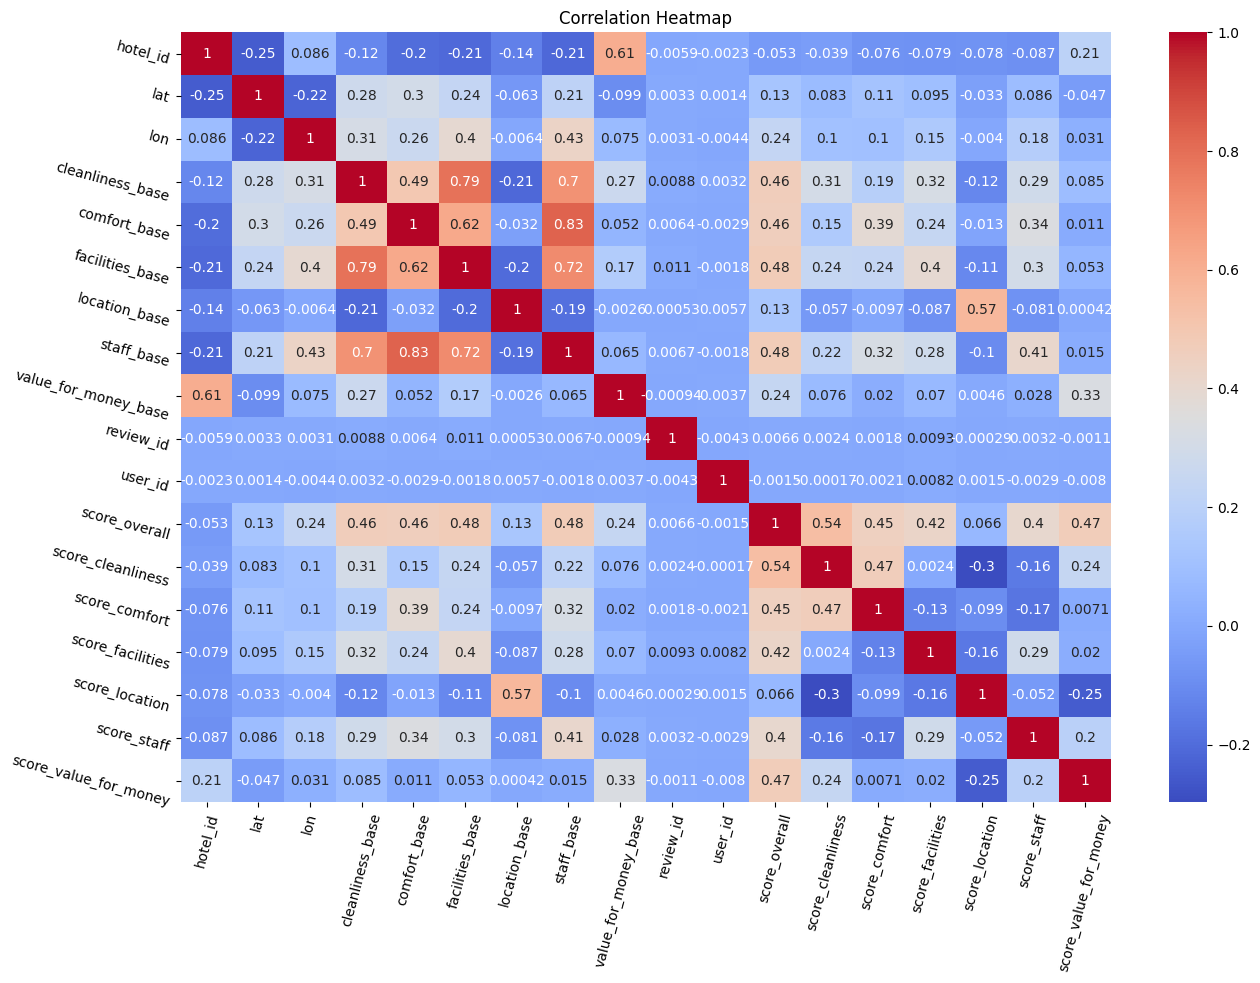

In [32]:
plt.figure(figsize=(15, 10))
sns.heatmap(df.drop('star_rating', axis=1).corr(numeric_only=True), cmap='coolwarm', annot=True)
plt.title('Correlation Heatmap')
plt.xticks(rotation=75)
plt.yticks(rotation=-15)

## 3. Data Preprocessing

In [33]:
# View column name
df.columns

Index(['hotel_id', 'hotel_name', 'city', 'hotel_county', 'star_rating', 'lat',
       'lon', 'cleanliness_base', 'comfort_base', 'facilities_base',
       'location_base', 'staff_base', 'value_for_money_base', 'review_id',
       'user_id', 'review_date', 'score_overall', 'score_cleanliness',
       'score_comfort', 'score_facilities', 'score_location', 'score_staff',
       'score_value_for_money', 'review_text', 'user_gender', 'user_country',
       'age_group', 'traveller_type', 'join_date'],
      dtype='object')

In [34]:
# Drop unnecessary column
df.drop(['lat', 'lon', 'review_date', 'review_text', 'join_date',
         'star_rating', 'hotel_id', 'review_id', 'user_id'], axis=1, inplace=True)

In [35]:
df.dtypes

hotel_name                object
city                      object
hotel_county              object
cleanliness_base         float64
comfort_base             float64
facilities_base          float64
location_base            float64
staff_base               float64
value_for_money_base     float64
score_overall            float64
score_cleanliness        float64
score_comfort            float64
score_facilities         float64
score_location           float64
score_staff              float64
score_value_for_money    float64
user_gender               object
user_country              object
age_group                 object
traveller_type            object
dtype: object

In [36]:
# Select categorical columns
cat_cols = df.select_dtypes(include=['object'])

# Label encoding
le = LabelEncoder()

for col in cat_cols:
    df[col] = le.fit_transform(df[col])

In [37]:
# Feature/Target separation
X = df.drop('score_overall', axis=1)
y = df['score_overall']

# Feature scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 4. Predictive Modeling

In [38]:
# Define baseline regression models for comparison
models = {
    'Linear Regression': LinearRegression(), 
    'Random Forest': RandomForestRegressor(n_estimators=200),
    'XG Boost': XGBRFRegressor(n_estimators=200)
}

In [39]:
results = {}
r2_results = {}

# Train each model and store predictions and R² scores
for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    results[name] = pred
    r2_results[name] = r2_score(y_test, pred)

In [40]:
# Display R² and RMSE scores for each model

for name, pred in results.items():
    print(name)
    print('R²:', r2_score(y_test, pred))
    print('RMSE:', root_mean_squared_error(y_test, pred))
    print('\n\n')

Linear Regression
R²: 0.9673599755009041
RMSE: 0.033193870878263046



Random Forest
R²: 0.9464101932395281
RMSE: 0.04253277882998013



XG Boost
R²: 0.7646105503488752
RMSE: 0.08914072439238235





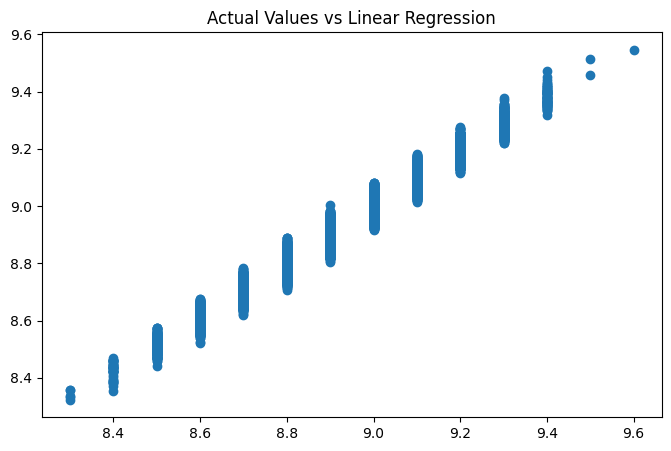

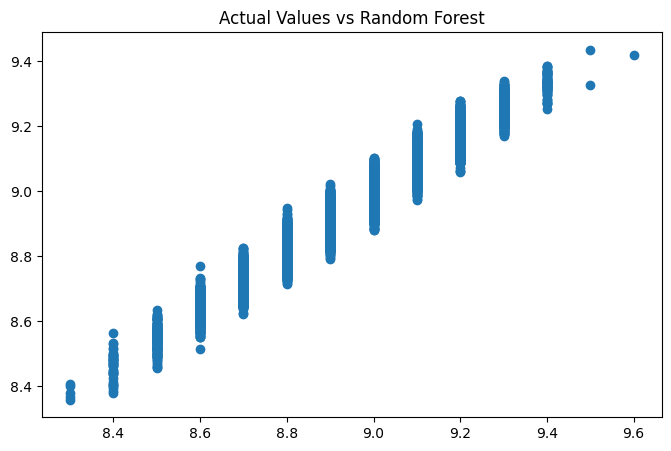

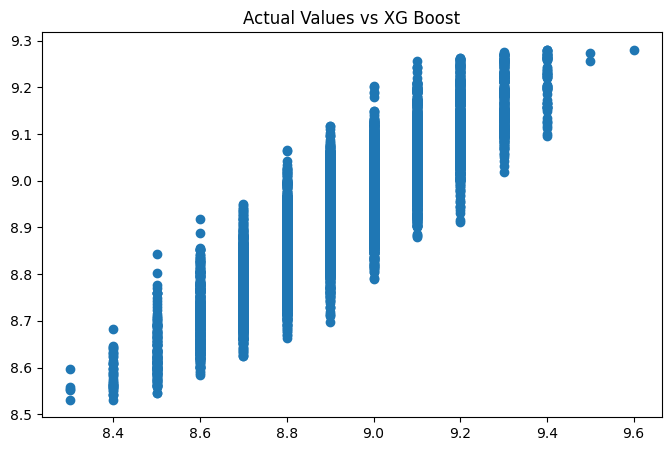

In [41]:
# Compareing actual target values y_test with predictions
for name, pred in results.items():
    plt.figure(figsize=(8, 5))
    plt.scatter(y_test, pred)
    plt.title(f'Actual Values vs {name}')

Text(0, 0.5, 'R² Score')

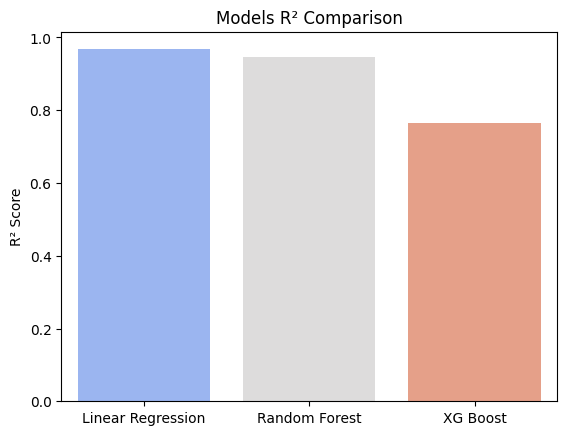

In [42]:
# Visualize R² scores to compare model performance
sns.barplot(x=list(r2_results.keys()), y=list(r2_results.values()), palette='coolwarm')
plt.title('Models R² Comparison')
plt.ylabel('R² Score')

## Conclusion

The regression models demonstrated varying levels of predictive performance. Linear Regression achieved the highest R² score (0.967) and the lowest RMSE (0.033), outperforming both Random Forest (R² = 0.946, RMSE = 0.043) and XGBoost (R² = 0.765, RMSE = 0.089). Visual comparisons confirmed Linear Regression’s superior alignment between predicted and actual values, with tighter clustering and minimal dispersion.

These results suggest that a simple linear model effectively captures the relationship between user feedback and overall satisfaction scores in this dataset. The modeling pipeline illustrates a complete predictive workflow—from data cleaning to evaluation—ready for deployment, stakeholder reporting, or further enhancement through feature engineering and cross-validation.